# EDSA - Climate Change Belief Analysis 2021
### Team TS5 Classification

<div align="center" style="width: 1000px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/CPNMorgan/Team_TS5_JHB_Classification/main/climat change.jpg"
     alt="Titanic"
     style="float: center; padding-bottom=0.5em"
     width=1000px/>

</div>

# Challenge Description

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

# Introduction

Theoretical (LogisticRegression, )
Problem/Hypothesis



We now know that the output value of a logistic regression model refers to the probability that the observation in question belongs to class 1. The output values all fall between 0 and 1, which is all very well. But at what threshold value do we decide that a probability is too low to be assigned to class 1? Usually, we pick 0.5. That is:

- Values greater than or equal to 0.5 are assigned to class 1; and
- Values less than 0.5 are assigned to class 0.

This output needs to hold for all values of X. In other words, regardless of the value of X, we need the output to be a value between 0 and 1. The function that takes care of all this is defined as follows:

$$P(X) = \displaystyle \frac{e^{\beta_0 + \beta_1 X}}{1+e^{\beta_0 + \beta_1 X}}$$

where $P(X)$ is the probability of X belonging to class 1, and $\beta_0$ and $\beta_1$ are the intercept and regression coefficient respectively, just like in a linear regression model. After a bit of manipulation we arrive at:

\begin{align}
1 - P(X) &= \displaystyle \frac{1}{1+e^{\beta_0 + \beta_1 X}} \\
\therefore \log \left( \frac{P(X)}{1-P(X)} \right) &= {\beta_0 + \beta_1 X}
\end{align}

<img src="useful_info/image5-13.jpg" align="center"/>

The term on the left is known as the **log odds ratio**. Without the log sign in front of it, it is known simply as the odds ratio. While $P(X)$ is bounded between 0 and 1, the odds ratio is bounded between 0 and $\infty$. 



# Importing Packages

In [1]:
#comet.ml
#import comet_ml
#from comet_ml import Experiment

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

#nlp
import string
import re    #for regex
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer,PorterStemmer, LancasterStemmer
from nltk.tokenize import RegexpTokenizer



from nltk.tokenize import TweetTokenizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_union
from wordcloud import WordCloud 
from collections import Counter
import emoji

#models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.utils import resample
from sklearn.metrics import classification_report

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Initialising Comet.ml Experiment Tracking

In [2]:
comet_ml.init()
experiment = Experiment(
            project_name="edsa-climate-change-sentiment-analysis/Default view",
            workspace="classification-ts5",
)

NameError: name 'comet_ml' is not defined

# Importing Datasets

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
print('Data imported succesfully')

Data imported succesfully


# First Look at the Data

In [4]:
train_df.head()

sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954

In [5]:
test_df.head()

message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928

In [6]:
#check the shape of the data
train_df.shape, test_df.shape

((15819, 3), (10546, 2))

In [7]:
#unique sentiments
train_df['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

In [8]:
#samples per sentiment
train_df['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [9]:
#trainig data statistics
train_df['sentiment'].describe()

count    15819.000000
mean         0.917504
std          0.836537
min         -1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: sentiment, dtype: float64

#checking for nulls
train_df.isnull().sum(), test_df.isnull().sum()

# DATA CLEANING

In [11]:
# creating copy of train_df
df = train_df.copy()

### Removing Noise

We will remove noise with the following steps:

- Convert letters to lowercase
- Remove URL links
- Remove numbers
- Remove punctuation

### Removing Stop Words

The most common words like "if", "but", "we", "he", "she" and "she" are referred to as *stop words*. We usually remove these words without changing the structure of the text, and could potentially improve the performance of a model. 
- Removing these stop words becomes much more useful when we use longer sequences of words as model features.

### Tokenisation
*Tokenization = process of breaking the raw text into small chunks, (i.e. tokens)* 

With the tweet data we will be splitting a string into a list of tokens. These tokens help in understanding the context or developing the model for the NLP. This helps in interpreting the meaning of the text by analyzing the sequence of the words. For example, the text “It is raining” can be tokenized into ‘It’, ‘is’, ‘raining’.
- Example: For example, the text “It is raining” can be tokenized into ‘It’, ‘is’, ‘raining’

A token is a part of a whole,e.g.  a word being a token in a sentence, and a sentence is a token in a paragraph. 

In [12]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_fil(sentence):
    '''function removes noise/cleans text data'''
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"")
    cleanr = re.compile('<.*?>') 
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)
    

In [13]:
def preprocess_stemm(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(stem_words)

In [14]:
def preprocess_lemm(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words ]
    return " ".join(lemma_words)

In [15]:
# cleaning the text messages and creates a new column named 'clean_message'
df['clean_message']=df['message'].map(lambda s:preprocess_fil(s))
df.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                       clean_message  
0  polyscimajor epa chief think carbon dioxide ma...  
1    like lack evidence anthropogenic global warming  
2  rawstory researchers say three years act clima...  
3  todayinmaker wired pivotal year war climate ch...  
4  soynoviodetodas racist sexist climate change d...

In [16]:
# lemmatizes the cleaned text data and creates new column named 'Lemma"
df['Lemma']=df['message'].map(lambda s:preprocess_lemm(s)) 
df.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                       clean_message  \
0  polyscimajor epa chief think carbon dioxide ma...   
1    like lack evidence anthropogenic global warming   
2  rawstory researchers say three years act clima...   
3  todayinmaker wired pivotal year war climate ch...   
4  soynoviodetodas racist sexist climate change d...   

                                               Lemma  
0  polyscimajor epa chief think carbon dioxide ma...  
1    like lack evidence anthropogenic global warming  
2  rawstory researcher say three year act climate...  
3  todayinmaker wired pivotal year war climate ch...  
4  soynoviodetodas racist sexist climate change d...

In [17]:
# stemmatize the cleaned text data and creates a new column named 'Stemm'
df['stemm']=df['message'].map(lambda s:preprocess_stemm(s)) 
df.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                       clean_message  \
0  polyscimajor epa chief think carbon dioxide ma...   
1    like lack evidence anthropogenic global warming   
2  rawstory researchers say three years act clima...   
3  todayinmaker wired pivotal year war climate ch...   
4  soynoviodetodas racist sexist climate change d...   

                                               Lemma  \
0  polyscimajor epa chief think carbon dioxide ma...   
1    like lack evidence anthropogenic global warming   
2  rawstory researcher say three year act climate...   
3  todayinmaker wired pivotal year war climate ch...   
4  soynoviodetodas racist sexist climate change d...   

                                               stemm  
0  polyscimajor epa chief think carbon dioxid mai...  
1             like lack evid anthropogen global warm  
2  rawstori research say three year act climat ch...  
3        todayinmak wire pivot year war climat chang  
4  soynoviodetoda racist sexist climat chang deni...

In [18]:
# proves that the lemmatization is applied to the 'clean_message' column
df['Lemma']==df['clean_message']

0         True
1         True
2        False
3         True
4        False
         ...  
15814    False
15815     True
15816    False
15817    False
15818     True
Length: 15819, dtype: bool

In [19]:
# proves that stemming is not equal to lemmatization
df['Lemma']==df['stemm']

0        False
1        False
2        False
3        False
4        False
         ...  
15814    False
15815    False
15816    False
15817    False
15818    False
Length: 15819, dtype: bool

## Exploratory Data Analysis (EDA)

 Exploratory Data Analysis (EDA) refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations

In [20]:
# Labeling the target
df['class_label'] = [['Negative(-1)', 'Neutral(0)', 'Positive(1)', 'News(2)'][x+1] for x in df['sentiment']]
df.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                       clean_message  \
0  polyscimajor epa chief think carbon dioxide ma...   
1    like lack evidence anthropogenic global warming   
2  rawstory researchers say three years act clima...   
3  todayinmaker wired pivotal year war climate ch...   
4  soynoviodetodas racist sexist climate change d...   

                                               Lemma  \
0  polyscimajor epa chief think carbon dioxide ma...   
1    like lack evidence anthropogenic global warming   
2  rawstory researcher say three year act climate...   
3  todayinmaker wired pivotal year war climate ch...   
4  soynoviodetodas racist sexist climate change d...   

                                               stemm  class_label  
0  polyscimajor epa chief think carbon dioxid mai...  Positive(1)  
1             like lack evid anthropogen global warm  Positive(1)  
2  rawstori research say three year act climat ch...      News(2)  
3        todayinmak wire pivot year war climat chang  Positive(1)  
4  soynoviodetoda racist sexist climat chang deni...  Positive(1)

#### Discreption of Sentiments:
- 2 News: the tweet links to factual news about climate change
- 1 Positive: the tweet supports the belief of man-made climate change
- 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
- -1 Negative: the tweet does not believe in man-made climate change

#### Count of words per sentiment

In [21]:
dist = df.groupby('class_label').count()['clean_message'].reset_index().sort_values(by='clean_message',ascending=False)
dist.style.background_gradient(cmap='Blues')

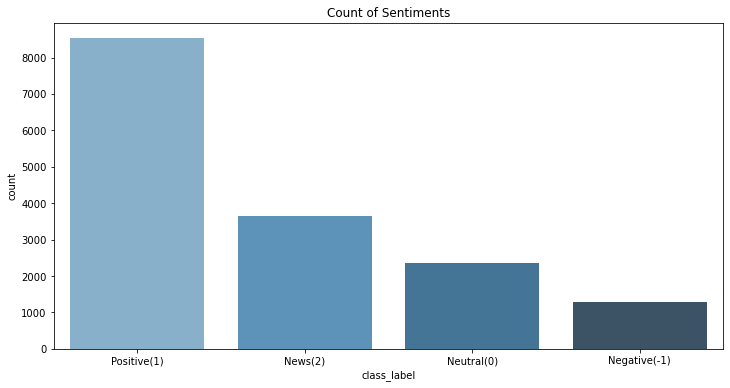

In [22]:
labels = []
plt.figure(figsize=(12,6))
sns.countplot(x='class_label',data=df, palette="Blues_d")
plt.title('Count of Sentiments')
plt.show()

### Observations
- As seen in the above bar graph, sentiment class 1 (8530 tweets) has the highest number of tweets in the train data, with the lowest sentiment class being class -1 (1296 tweets).
- The distribution of sentiments classes are imbalanced due the classes not having the same amount of tweets in their class as seen in dataframe which compares the value counts and % of each sentiment class.

**The class imbalance of the training data would have an impact on the unseen testing data when coming to the modeling phase:**

- A class imbalance could result in the model classifying majority of the tweets into sentiment ***class 1 (Positive)*** since the model gets most data with classifying class 1 tweets.

## Relation between length of text and sentiment

Text(0, 0.5, 'Count of Tweets')

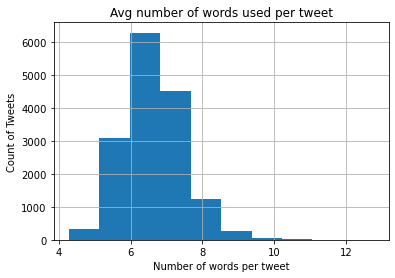

In [23]:
# average length of words overall
df['clean_message'].str.split().\
    apply(lambda x : [len(i) for i in x]).\
    map(lambda x : np.mean(x)).hist()
plt.title('Avg number of words used per tweet')
plt.xlabel('Number of words per tweet')
plt.ylabel('Count of Tweets')

### Observations
- The graph above shows that the words in the positive sentiment are higher compare to others, with 8000 words, were by the rest are below 4000

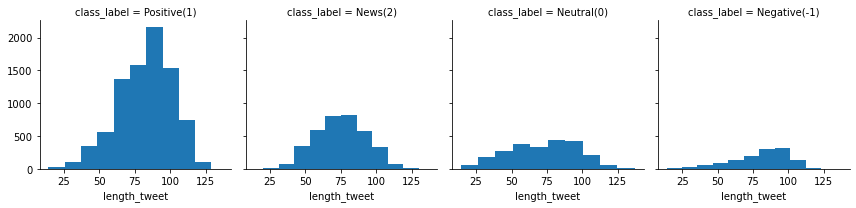

In [24]:
#Distribution of length of words per sentiment

df['length_tweet'] = df['clean_message'].apply(len)
h = sns.FacetGrid(df,col = 'class_label')
h.map(plt.hist,'length_tweet')
plt.show()

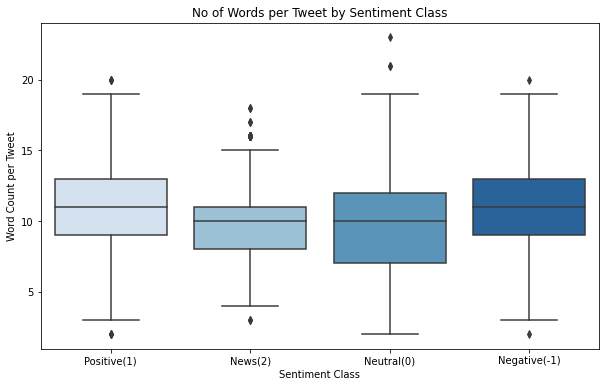

In [25]:
#Box plot visual of distribution between length of tweet vs class label
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['class_label'],
            y=df.clean_message.str.split().apply(len),
            data=df,
            palette="Blues")

plt.title('No of Words per Tweet by Sentiment Class')
plt.xlabel('Sentiment Class')
plt.ylabel('Word Count per Tweet');



### Observations
- It's relevant to analyse the sentiment distribution of wordcounts. The boxplot shows that there isn't much difference between wordcounts between classes and therefor no need to add a 'wordcount' feature to the classification algorithms. 
- Note:
Twitter limits tweet to 250 characters, meaning an underlying association between sentiment and average word count won't  really reflect in this context.

## Funnel chart to get more insight from sentiments

In [26]:
fig = go.Figure(go.Funnelarea(
    text =dist.class_label,
    values = dist.clean_message,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

### Observation
- Negative(-1) Sentiment shows the less of counted words with the percentage of 8.19
- Neutral(0) shows 14.9 percents of counted words
- News(2) shows 23 percents of counted words
- And Positive comments shows the highest percentage of 53.9 of counted words

## Checking average length of each sentiment catergory

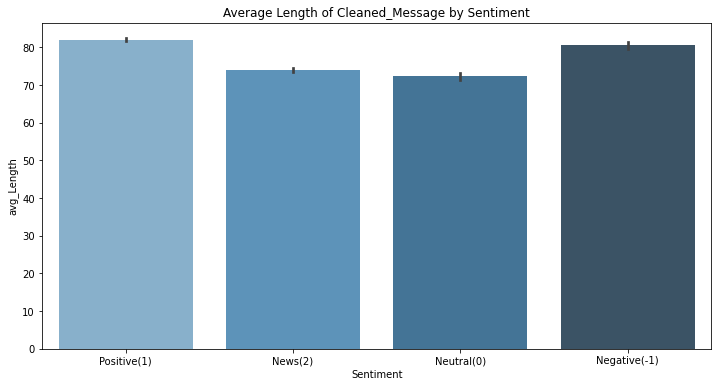

In [27]:
# avarage length of words per sentiment category
plt.figure(figsize=(12,6))
sns.barplot(x='class_label', y=df['clean_message'].apply(len) ,data = df, palette='Blues_d')
plt.ylabel('avg_Length')
plt.xlabel('Sentiment')
plt.title('Average Length of Cleaned_Message by Sentiment')
plt.show()

In [28]:
#View of average length of tweet

rel = df.groupby('sentiment').mean()
round(rel,2)

tweetid  length_tweet
sentiment                         
-1         499169.45         80.51
 0         496550.25         72.33
 1         507418.55         82.04
 2         492613.50         74.04

### Observations:
 - On average tweet length is between 70 - 80 words for each sentiment category

## Most Common words in our Target-Selected Message

In [29]:

df['new_lis'] = df['clean_message'].apply(lambda x:str(x).split())
words = Counter([item for sublist in df['new_lis'] for item in sublist])
new = pd.DataFrame(words.most_common(20))
new.columns = ['Common_words','count']
new.style.background_gradient(cmap='Blues')

In [30]:
import plotly.express as px
fig = px.bar(new, x="count", y="Common_words", color_discrete_sequence =['blue']*len(df), title='Commmon Words in tweet messages', orientation='h', 
             width=600, height=600)
fig.show()

## Most common words Sentiments Wise

In [31]:
Positive = df[df['sentiment']==1]
Negative = df[df['sentiment']==-1]
Neutral = df[train_df['sentiment']==0]
News = df[df['sentiment']==2]


### Most common positive(1) words

In [32]:
#MosT common positive words
top = Counter([item for sublist in Positive['new_lis'] for item in sublist])
positive_w = pd.DataFrame(top.most_common(20))
positive_w.columns = ['Common_words','count']
positive_w.style.background_gradient(cmap='Greens')

In [33]:
fig = px.bar(positive_w, x="count", y="Common_words", title='Most Commmon Positive(1) Words', orientation='h', 
             width=600, height=600)
fig.show()

### Observations:
 -

### Most common negative words

In [34]:

top = Counter([item for sublist in Negative['new_lis'] for item in sublist])
negative = pd.DataFrame(top.most_common(20))
negative = negative.iloc[1:,:]
negative.columns = ['Common_words','count']
negative.style.background_gradient(cmap='Reds')

In [35]:
fig = px.bar(negative, x="count", y="Common_words", title='Most Commmon Negative(-1) Words', orientation='h', 
             width=600, height=600)
fig.show()

### Most common neutral(0) words

In [36]:
top = Counter([item for sublist in Neutral['new_lis'] for item in sublist])
neutral = pd.DataFrame(top.most_common(20))
neutral = neutral.iloc[1:,:]
neutral.columns = ['Common_words','count']
neutral.style.background_gradient(cmap='Blues')

In [37]:
fig = px.bar(neutral, x="count", y="Common_words", title='Most Commmon Neutral(0) Words', orientation='h', 
             width=600, height=600)
fig.show()

### Most common news(2) words

In [38]:
top = Counter([item for sublist in News['new_lis'] for item in sublist])
news = pd.DataFrame(top.most_common(20))
news = news.iloc[1:,:]
news.columns = ['Common_words','count']
news.style.background_gradient(cmap='Reds')

In [39]:
fig = px.bar(news, x="count", y="Common_words", title='Most Commmon Neutral(0) Words', orientation='h', 
             width=600, height=600)
fig.show()

### Counting number of Emojis used in the texts

In [40]:
import emoji
emojis_df=[]
for string in df['message']:
    my_str = str(string)
    for each in my_str:
        if each in emoji.UNICODE_EMOJI['en'].keys():
            emojis_df.append(each)
freq = (Counter(i for sub in emojis_df for i in set(sub))) 
sort_orders = sorted(freq.items(), key=lambda x: x[1], reverse=True)

In [41]:
print(sort_orders)

[('😂', 28), ('™', 13), ('🤔', 11), ('🙄', 11), ('❤', 11), ('🔥', 10), ('❄', 8), ('🤣', 8), ('🌍', 7), ('➡', 7), ('🌎', 6), ('☀', 6), ('😳', 5), ('🏽', 5), ('💀', 5), ('▶', 5), ('🙃', 4), ('⚡', 4), ('😢', 4), ('✔', 4), ('♂', 3), ('©', 3), ('😜', 3), ('👏', 3), ('♀', 3), ('✨', 3), ('😒', 2), ('🏻', 2), ('🏼', 2), ('🚨', 2), ('🌏', 2), ('😔', 2), ('😩', 2), ('🤐', 2), ('♥', 2), ('😄', 2), ('🎵', 2), ('😁', 2), ('☕', 2), ('😅', 2), ('😍', 2), ('‼', 2), ('😲', 2), ('✈', 2), ('💚', 2), ('🤦', 1), ('✊', 1), ('😑', 1), ('☔', 1), ('👎', 1), ('🙏', 1), ('😇', 1), ('🙋', 1), ('🔫', 1), ('🤰', 1), ('🌼', 1), ('😞', 1), ('😴', 1), ('☢', 1), ('⛰', 1), ('☹', 1), ('😫', 1), ('⏩', 1), ('😊', 1), ('⏰', 1), ('🤗', 1), ('🌴', 1), ('🌳', 1), ('🌲', 1), ('🌻', 1), ('🍄', 1), ('🌤', 1), ('🌱', 1), ('🦋', 1), ('🐞', 1), ('🐾', 1), ('🌈', 1), ('🏔', 1), ('🙁', 1), ('🏊', 1), ('☝', 1), ('♋', 1), ('💍', 1), ('👌', 1), ('🤡', 1), ('👀', 1), ('👍', 1), ('🖐', 1), ('👑', 1), ('😎', 1), ('📝', 1), ('☎', 1), ('⬅', 1), ('🦄', 1), ('✅', 1), ('📢', 1), ('😖', 1), ('😬', 1), ('🙂', 1), ('🐝

In [42]:
#function for emoji extraction
def ext_emoji(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI['en'].keys())

In [43]:
#extracting emojis from train data

df['emoji'] = df['message'].apply(ext_emoji)
df[df['emoji']!='']['emoji']

56       😂❄❄🤦♂
121          🤔
209       😂🔥🌎❄
230          ♂
488         🙄🙄
         ...  
15506        ⬆
15669        😠
15671        😄
15695        ⚡
15723        😨
Name: emoji, Length: 179, dtype: object

### Observation:
- The most common emoji is the 'face with tears of joy' is an emoji featuring a jovial face laughing, while also crying out tears
- We have other emojis that illustrate the impacts of global warmaing on weather and climate change, e.g 'earth,fire,flowers and snowflake'

***

## WordCloud
- Wordcloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance
- The larger the word in the visual the more common the word is on tweet messages.

### WordCloud of most common *positive* words used.


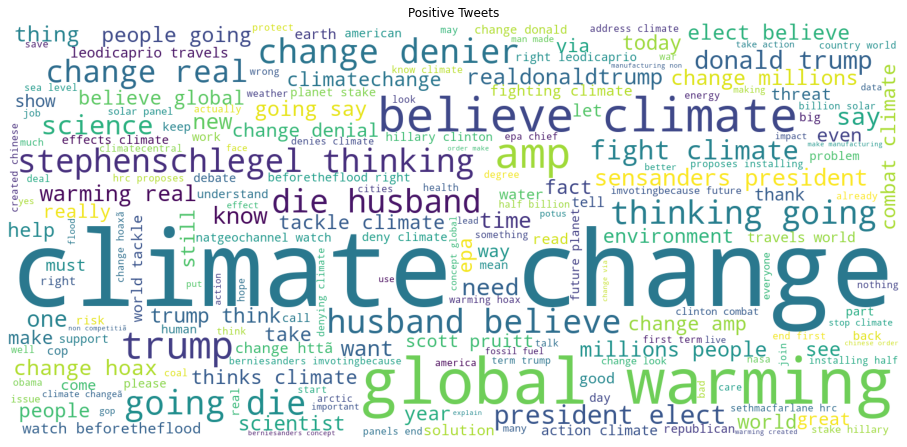

In [44]:
wordcloud = WordCloud(max_font_size=250,background_color='white', width=1500, height=700).generate(' '.join(Positive[Positive['sentiment'] == 1]
                                          ['clean_message']))
plt.figure( figsize=(16,10))
plt.imshow(wordcloud)
plt.title('Positive Tweets')
plt.axis("off")
plt.show()

### Observations:
 - Words like "believe", "change", "science", further prove that people believe that the climate change is casued by humans and it is going to be a huge probvlem in the neatr future.

### WordCloud of most common *negative* words used

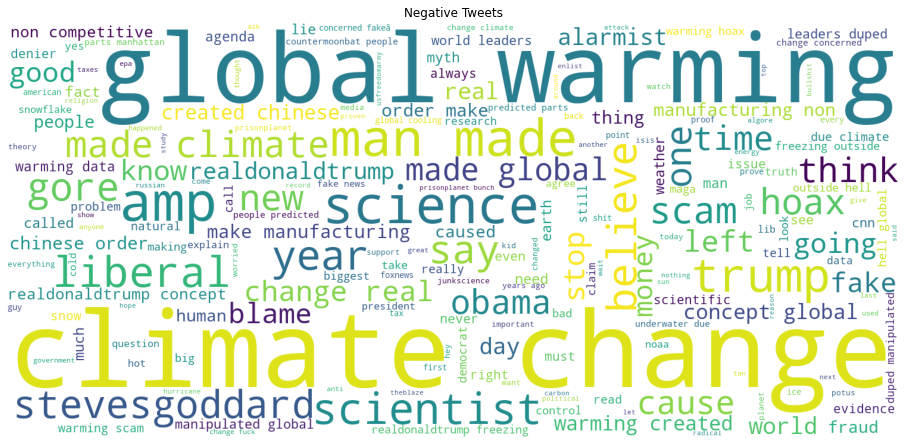

In [45]:
wordcloud = WordCloud(max_font_size=250,background_color='white', width=1500, height=700).generate(' '.join(Negative[Negative['sentiment'] == -1]
                                          ['clean_message']))
plt.figure( figsize=(16,10))
plt.imshow(wordcloud)
plt.title('Negative Tweets')
plt.axis("off")
plt.show()

### Observations:
 - Words like "hoax", "scam", "blame", "fake", are frequently used as adjectives that are used in arguments, which implies that people are against the belief of climate change being casued by humans.

### WordCloud of most common *neutral* words used

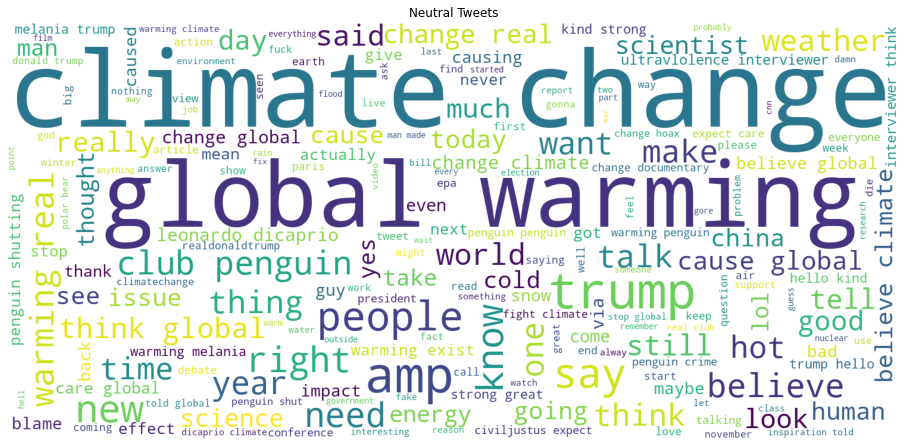

In [46]:
wordcloud = WordCloud(max_font_size=250,background_color='white', width=1500, height=700).generate(' '.join(Neutral[Neutral['sentiment'] == 0]
                                          ['clean_message']))
plt.figure( figsize=(16,10))
plt.imshow(wordcloud)
plt.title('Neutral Tweets')
plt.axis("off")
plt.show()

### Observations:
 - Words like "think", "make", "look", "said", are words which are used around uncertainty regrading a subject, which implies that people are on the fence regrading the belief of climate change being casued by humans.

### WordCloud of most common *news* words used

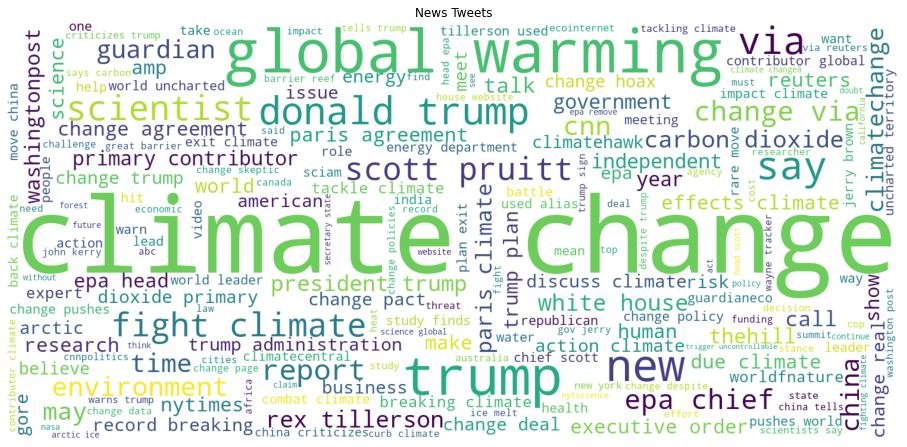

In [47]:
wordcloud = WordCloud(max_font_size=250,background_color='white', width=1500, height=700).generate(' '.join(News[News['sentiment'] == 2]
                                          ['clean_message']))
plt.figure( figsize=(16,10))
plt.imshow(wordcloud)
plt.title('News Tweets')
plt.axis("off")
plt.show()

### Observations:
 - Words like "trump", "white house", "chief", "republican", are all political words which are used around breaking news articles.

### WordCloud of most common words used 'Overall'


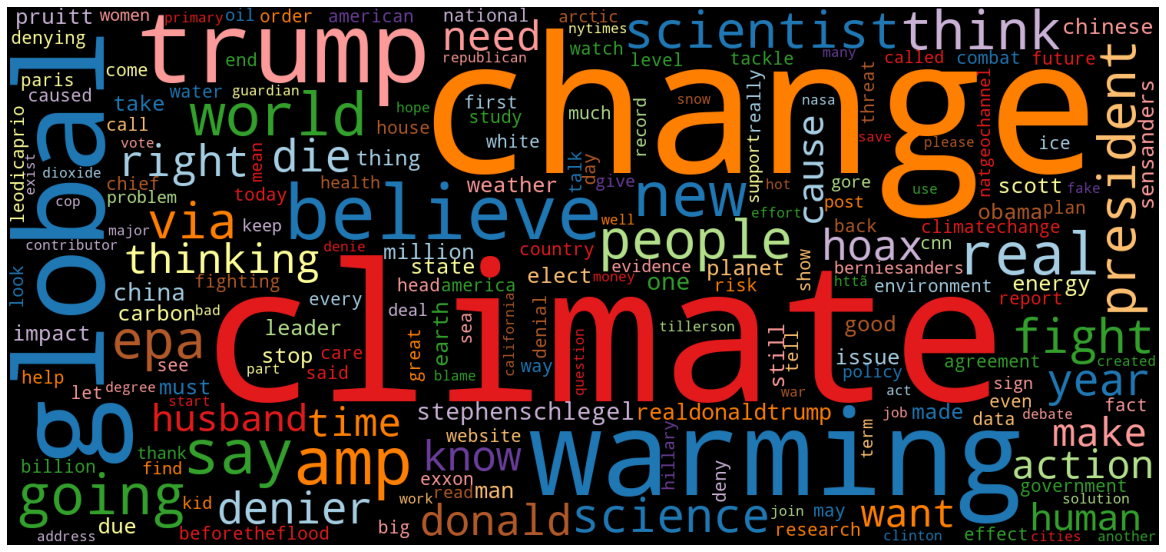

In [48]:
train_msg = " ".join(tweet for tweet in df.clean_message)
train_wordcloud = WordCloud(max_font_size=250,
                            background_color="black",
                            width=1500,
                            height=700,
                            collocations=False,
                            colormap='Paired').generate(train_msg)
plt.figure(figsize=(16, 10))
plt.imshow(train_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Observation:
 - From the above wordcloud for overall words, we observe the words "climate","Trump","change", "global", "warming" as the most frequently tweeted ones, with "Climate Change" being the most evident.

***

## Balancing Data

In [49]:

# Separate minority and majority classes
majority_sentiment = df[df['sentiment']== 1]
minority_sentiment_0 = df[df['sentiment']== 0]
minority_sentiment_2 = df[df['sentiment']== 2]
minority_sentiment_neg1 = df[df['sentiment'] == -1]

# Upsample minority

### Upsampling: 

We simply make random copies of observations in the minority class until we match the size of the majority class. Using this approach means we end up with more data

In [50]:
minority_sentiment_0_minority = resample(minority_sentiment_0,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=len(majority_sentiment), # match number in minority class
                          random_state=42) # reproducible results

minority_sentiment_2_minority = resample(minority_sentiment_2,
                                         replace = True,
                                         n_samples=len(majority_sentiment),
                                         random_state=42)

minority_sentiment_neg1_minority = resample(minority_sentiment_neg1,
                                   replace=True,
                                   n_samples=len(majority_sentiment),
                                   random_state=42)

# Combine upsampled minority class with majority class
df2 = pd.concat([majority_sentiment, minority_sentiment_0_minority,minority_sentiment_2_minority,minority_sentiment_neg1_minority])

# Check new class counts
df2['sentiment'].value_counts()

 0    8530
 1    8530
 2    8530
-1    8530
Name: sentiment, dtype: int64

## Downsample 

### Downsampling:

This approach reduces the overall size of the dataset, it makes sense to use it only in cases where we have a big collection of data.

In [51]:
# Separate minority and majority classes
majority_sentiment = df[df['sentiment']== 1]
minority_sentiment_0 = df[df['sentiment']== 0]
minority_sentiment_2 = df[df['sentiment']== 2]
minority_sentiment_neg1 = df[df['sentiment'] == -1]


Pro = resample(majority_sentiment,##PRO,
                          replace=False, # sample with replacement (we need to duplicate observations)
                          n_samples=len(minority_sentiment_neg1), # match number in minority class
                          random_state=42) # reproducible results

Neutral = resample(minority_sentiment_0,##NEUTRAL,
                                         replace = False,
                                         n_samples=len(minority_sentiment_neg1),
                                         random_state=42)

news = resample(minority_sentiment_2,##NEWS,
                                   replace=False,
                                   n_samples=len(minority_sentiment_neg1),
                                   random_state=42)

# Combine upsampled minority class with majority class
df_down = pd.concat([Pro,Neutral,news,minority_sentiment_neg1])

# Check new class counts
df_down['sentiment'].value_counts()

 0    1296
 1    1296
 2    1296
-1    1296
Name: sentiment, dtype: int64

In [52]:
#n_samples=len(Anti)

In [53]:
# Show the table of balanced data in clean_text from each language Id
dist = df2.groupby('sentiment').count()['clean_message'].reset_index().sort_values(by='clean_message',ascending=True)

In [54]:
dist

sentiment  clean_message
0         -1           8530
1          0           8530
2          1           8530
3          2           8530

# UP AND DOWN

In [55]:
# Separate minority and majority classes
majority_sentiment = df[df['sentiment']== 1]
minority_sentiment_0 = df[df['sentiment']== 0]
minority_sentiment_2 = df[df['sentiment']== 2]
minority_sentiment_neg1 = df[df['sentiment'] == -1]

# Downsample majority
class_size=round(len(majority_sentiment)/2)
Pro_downsampled2 = resample(majority_sentiment,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=class_size, # match number in class size
                          random_state=30) # reproducible results

# Combine downsampled majority class with minority class
#downsampled = pd.concat([not_spam_downsampled, spam])

# Upsample minority
News_upsampled = resample(minority_sentiment_2,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=class_size, # match number in  class size
                          random_state=31) # reproducible results

Neutral_upsampled = resample(minority_sentiment_0,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=class_size, # match number in  class size
                          random_state=32) # reproducible results

Anti_upsampled = resample(minority_sentiment_neg1,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=class_size, # match number in  class size
                          random_state=33) # reproducible results



# Combine upsampled minority class with majority class
upsampled_downsampled = pd.concat([News_upsampled,Neutral_upsampled,Anti_upsampled, Pro_downsampled2])
# Check new class counts
upsampled_downsampled['sentiment'].value_counts()

 0    4265
 1    4265
 2    4265
-1    4265
Name: sentiment, dtype: int64

In [56]:
upsampled_downsampled.head(2)

sentiment                                            message  tweetid  \
2944          2  City of Montreal to buy refrigerated skating r...   445397   
8776          2  Trump to sign sweeping rollback of Obama-era c...   245157   

                                          clean_message  \
2944  city montreal buy refrigerated skating rinks c...   
8776  trump sign sweeping rollback obama era climate...   

                                                  Lemma  \
2944  city montreal buy refrigerated skating rink co...   
8776  trump sign sweeping rollback obama era climate...   

                                                  stemm class_label  \
2944  citi montreal buy refriger skate rink counter ...     News(2)   
8776  trump sign sweep rollback obama era climat cha...     News(2)   

      length_tweet                                            new_lis emoji  
2944            83  [city, montreal, buy, refrigerated, skating, r...        
8776            59  [trump, sign, sweeping, rollback, obama, era, ...

***

## Data Preprosessing

### Train (Validation) Test Split

In [57]:
df['stemm']#Unbalanced

0        polyscimajor epa chief think carbon dioxid mai...
1                   like lack evid anthropogen global warm
2        rawstori research say three year act climat ch...
3              todayinmak wire pivot year war climat chang
4        soynoviodetoda racist sexist climat chang deni...
                               ...                        
15814    ezlusztig took materi global warm lgbt right h...
15815    washingtonpost climat chang could break millio...
15816    notiven nytimesworld trump actual believ clima...
15817    sarasmil hey liber climat chang crap hoax tie ...
15818    chet_cannon kurteichenwald climat chang equat ...
Name: stemm, Length: 15819, dtype: object

In [58]:
df2.head()# Upsampled balanced

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   
5          1  Worth a read whether you do or don't believe i...   425577   

                                       clean_message  \
0  polyscimajor epa chief think carbon dioxide ma...   
1    like lack evidence anthropogenic global warming   
3  todayinmaker wired pivotal year war climate ch...   
4  soynoviodetodas racist sexist climate change d...   
5          worth read whether believe climate change   

                                               Lemma  \
0  polyscimajor epa chief think carbon dioxide ma...   
1    like lack evidence anthropogenic global warming   
3  todayinmaker wired pivotal year war climate ch...   
4  soynoviodetodas racist sexist climate change d...   
5          worth read whether believe climate change   

                                               stemm  class_label  \
0  polyscimajor epa chief think carbon dioxid mai...  Positive(1)   
1             like lack evid anthropogen global warm  Positive(1)   
3        todayinmak wire pivot year war climat chang  Positive(1)   
4  soynoviodetoda racist sexist climat chang deni...  Positive(1)   
5             worth read whether believ climat chang  Positive(1)   

   length_tweet                                            new_lis emoji  
0            87  [polyscimajor, epa, chief, think, carbon, diox...        
1            47  [like, lack, evidence, anthropogenic, global, ...        
3            50  [todayinmaker, wired, pivotal, year, war, clim...        
4            86  [soynoviodetodas, racist, sexist, climate, cha...        
5            41   [worth, read, whether, believe, climate, change]

### Our train dataframes for checking model performance

- df : unbalanced data-set
- df2 : Upsampled data-set
- df_down : downsampled data-set
- upsampled_downsampled : balanced data-set


In [59]:
X = df2['stemm']
y = df2['sentiment']

- df2 Upsampled data is our best performing model

*Upsampling_Downsampling our data makes model performance worse*

- X = upsampled_downsampled [ ' clean_message ' ]
- y = upsampled_downsampled [ ' sentiment ' ]

*Down sampling our data makes model performance* **worse** - due to us having very *little* training data here


- X = df_down [ ' clean_message ' ]
- y = df_down [ ' sentiment ' ]

In [60]:
df2.shape

(34120, 10)

# Train_Test Split 

In [61]:
ts = .1
rs = 42

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=ts, random_state=rs)

#experiment.log_parameters({"test size": ts, "random state": rs})

***

# Classification Models 
[Back to Table of Contents](#toc)

## Different Models

### *K-nearest neighbours:*

K-nearest neighbors (KNN) is a powerful, yet easy to understand machine learning algorithm. In principle, this algorithm works by **assigning the majority class of the N closest neighbors to the currect data point**. As such, absolutely no training is required for the algorithm! 
- All we do is choose K (i.e. the number of neighbors to consider), choose a distance function to calculate proximity and we're good to go.

### *Decision Trees:*

A decision tree is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences. Decision trees are **extremely intuitive ways to classify objects or predict continuous values**: you simply ask a series of questions designed to zero-in on the classification/prediction. 
-  In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data, that is, each node in the tree splits the data into two groups using a cutoff value within one of the features.

### *Random Forest:*

A random forest is a powerful non-parametric algorithm that is an example of an ensemble method built on decision trees, meaning that it **relies on aggregating the results of an ensemble of decision trees**. The ensemble of trees are randomized and the output is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

### *Complement Naive Bayes:*

The Complement Naive Bayes classifier was designed to correct the “severe assumptions” made by the standard Multinomial Naive Bayes classifier. It is particularly suited for imbalanced data sets.

### *Multinomial Naive Bayes:*

The Multinomial Naive Bayes model **estimates the conditional probability of a particular feature** given a class and uses a multinomial distribution for each of the features. The model assumes that each feature makes an independent and equal contribution to the outcome.

### *AdaBoost Classifier:*

AdaBoost classifier builds a strong classifier by **combining multiple poorly performing classifiers** so that you will get high accuracy strong classifier. 

***

In [97]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
clf_dict = [LinearSVC(random_state=42), KNeighborsClassifier(n_neighbors=5),DecisionTreeClassifier(max_depth=5),
                        RandomForestClassifier(max_depth=5, n_estimators=10,
                        max_features=1), ComplementNB(), MultinomialNB(), AdaBoostClassifier()
                         ]

In [102]:
def modeling(clf_dict, X_train, y_train, X_val, y_val):
    import pickle
    
    
        
    models = {}
    for clf in clf_dict:
        clf_text = Pipeline([('tfidf', TfidfVectorizer(min_df=1, max_df=0.1, ngram_range=(1, 2))),('clf', clf)])
        
        clf_text.fit(X_train, y_train)
        predictions = clf_text.predict(X_val)
        print(str(clf),'\n',classification_report(predictions,y_val))
        # Output for each model
        
        model_save_path=str(clf)+".pkl"
        with open(model_save_path,'wb') as file:
            pickle.dump(clf_text,file)
            
        models[clf.__class__.__name__] = {
            'F1-Macro': metrics.f1_score(y_val,predictions,average='macro'),
            'F1-Mccuracy': metrics.f1_score(y_val, predictions,average='micro'),
            'F1-Weighted': metrics.f1_score(y_val,predictions,average='weighted')}

    return pd.DataFrame.from_dict(models, orient='index')

In [103]:
# Displaying all the models
classi = modeling(clf_dict, X_train, y_train, X_val, y_val)
display_df = classi.sort_values('F1-Macro', ascending=False)
display_df

LinearSVC(random_state=42) 
               precision    recall  f1-score   support

          -1       1.00      0.96      0.98       907
           0       0.98      0.94      0.96       871
           1       0.83      0.97      0.89       729
           2       0.97      0.91      0.94       905

    accuracy                           0.94      3412
   macro avg       0.94      0.94      0.94      3412
weighted avg       0.95      0.94      0.94      3412

KNeighborsClassifier() 
               precision    recall  f1-score   support

          -1       0.98      0.85      0.91      1005
           0       0.98      0.48      0.65      1702
           1       0.18      0.97      0.30       155
           2       0.63      0.97      0.77       550

    accuracy                           0.69      3412
   macro avg       0.69      0.82      0.66      3412
weighted avg       0.89      0.69      0.73      3412

DecisionTreeClassifier(max_depth=5) 
               precision    recall  f1-

C:\Users\SenseiFire\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\SenseiFire\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\SenseiFire\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10) 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.75      0.01         4
           1       0.00      0.00      0.00         0
           2       1.00      0.25      0.40      3408

    accuracy                           0.25      3412
   macro avg       0.25      0.25      0.10      3412
weighted avg       1.00      0.25      0.40      3412

ComplementNB() 
               precision    recall  f1-score   support

          -1       1.00      0.89      0.94       984
           0       0.95      0.91      0.93       879
           1       0.61      0.96      0.75       542
           2       0.97      0.82      0.89      1007

    accuracy                           0.88      3412
   macro avg       0.88      0.89      0.88      3412
weighted avg       0.92      0.88      0.89      3412

MultinomialNB() 
               precision 

F1-Macro  F1-Mccuracy  F1-Weighted
LinearSVC               0.942088     0.943435     0.942278
MultinomialNB           0.884499     0.889801     0.884668
ComplementNB            0.875870     0.883353     0.875993
KNeighborsClassifier    0.655586     0.692556     0.657022
AdaBoostClassifier      0.516836     0.519637     0.517324
DecisionTreeClassifier  0.228200     0.312134     0.227125
RandomForestClassifier  0.100913     0.247948     0.099834

Hence Our two Best Performing models are The LinearSVC and MultinomialNB Models

## Performance Visuals

In [65]:
#Compare Performance between models visually

#fig,axis = plt.subplots(figsize=(10,5))
#rmse_x = ['LinearSVC', 'KNeighborsClassifier','DecisionTreeClassifier','RandomForestClassifier', 'ComplementNB', 'MultinomialNB', 'AdaBoostClassifier']
#rmse_y = clf_dict
#ax = sns.barplot(x=rmse_x, y=rmse_y, palette=('Blues_d'))
#plt.title('Weighted F1-Score per Model', fontsize=14)
#plt.xticks(rotation=90)
#plt.ylabel('Weighted F1-Score')
#for p in ax.patches:
#    ax.text(p.get_x() + p.get_width()/2, p.get_height(), round(p.get_height(), 2), fontsize=12, ha='center', va='bottom')
    
#plt.show()

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

### Running a Single model

In [86]:
from sklearn.pipeline import Pipeline
param_grid = {'alpha': [0.1, 1, 5, 11]}  # parameter grid

pipeline = Pipeline([('tfidf', TfidfVectorizer(min_df=2, max_df=0.9, ngram_range=(1, 3))), ('mnb', GridSearchCV(MultinomialNB(),  param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1_weighted'))])


In [87]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 3))),
                ('mnb',
                 GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
                              param_grid={'alpha': [0.1, 1, 5, 11]},
                              scoring='f1_weighted'))])

In [88]:
predictions = pipeline.predict(X_val)

In [70]:
print(classification_report(predictions,y_val))

              precision    recall  f1-score   support

          -1       0.99      0.97      0.98       900
           0       0.91      0.95      0.93       800
           1       0.88      0.86      0.87       873
           2       0.92      0.92      0.92       839

    accuracy                           0.92      3412
   macro avg       0.92      0.92      0.92      3412
weighted avg       0.92      0.92      0.92      3412



In [ ]:
# Pickle file for each model

In [106]:
import pickle



In [111]:
model_load_path = "GridSearch_NB.pkl"
with open(model_load_path,'rb') as file:
    unpickled_GB_model = pickle.load(file)

In [93]:
pred=unpickled_GB_model.predict(X_val)

In [94]:
print(classification_report(predictions,y_val))

              precision    recall  f1-score   support

          -1       0.99      0.97      0.98       900
           0       0.91      0.95      0.93       800
           1       0.88      0.86      0.87       873
           2       0.92      0.92      0.92       839

    accuracy                           0.92      3412
   macro avg       0.92      0.92      0.92      3412
weighted avg       0.92      0.92      0.92      3412



In [72]:
f1_Macro = metrics.f1_score(y_val,predictions,average='macro')
f1_Mccuracy = metrics.f1_score(y_val, predictions,average='micro'),
f1_Weighted =  metrics.f1_score(y_val,predictions,average='weighted')

In [73]:
experiment.log_metric("f1-Macro", f1_Macro)
experiment.log_metric("f1-Mccuracy", f1_Mccuracy)
experiment.log_metric("f1-Weighted", f1_Weighted)

NameError: name 'experiment' is not defined

## Prediction Submission csv

In [253]:
Model = pd.DataFrame(data={'tweetid': test_df['tweetid'],'sentiment': predictions})

In [254]:
Model.to_csv("GridSearchStemmaFinal2.csv", index=False)
#OUR MODEL IMPROVED BY USING STEMMA BETTER THAN LEMMA AND WE USED UPSAMPLED DATA WITH TRAINING DATA OF 90%

In [ ]:
experiment.end()

## References
- Websites used for insipiration

- analyticsvidhya: https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/
- towardsdatascience: https://towardsdatascience.com/how-to-efficiently-remove-punctuations-from-a-string-899ad4a059fb
- codegrepper:  https://www.codegrepper.com/code-examples/python/pandas+series+remove+punctuation
- https://stackoverflow.com/questions/54396405/how-can-i-preprocess-nlp-text-lowercase-remove-special-characters-remove-numb
